# Question 1

The first question requires the implementation of the Fourier Transform to convert signal from the time domain to the frequency domain. We want to find the harmonics of a square wave in the frequency domain using the Fourier transform, and then examine how these harmonics can be combined to reconstruct the square wave. 

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [66]:
# Set parameters for the signal
N = 2048                # Number of sample points
T = 1.0                  # Duration of the signal in seconds
f0 = 1                   # fundamental frequency of the square wave in Hz

# list of harmonic numbers when constructing square wave
harmonics = [1, 3, 5]

In [67]:
# Reconstruct a square function (square wave) by summing sine waves of different frequencies using Fourier series.

# Define square wave function
def square_wave(t):
    return np.sign(np.sin(2.0 * np.pi * f0 * t))

# Fourier series approximation of square wave
def square_wave_fourier(t, f0, N):
    result = np.zeros_like(t)
    for k in range(N):
        n = 2 * k + 1  # Fourier series of a square wave only contains odd harmonics
        result += np.sin(2 * np.pi * n * f0 * t) / n # add harmonics to reconstruct square function
    return (4 / np.pi) * result

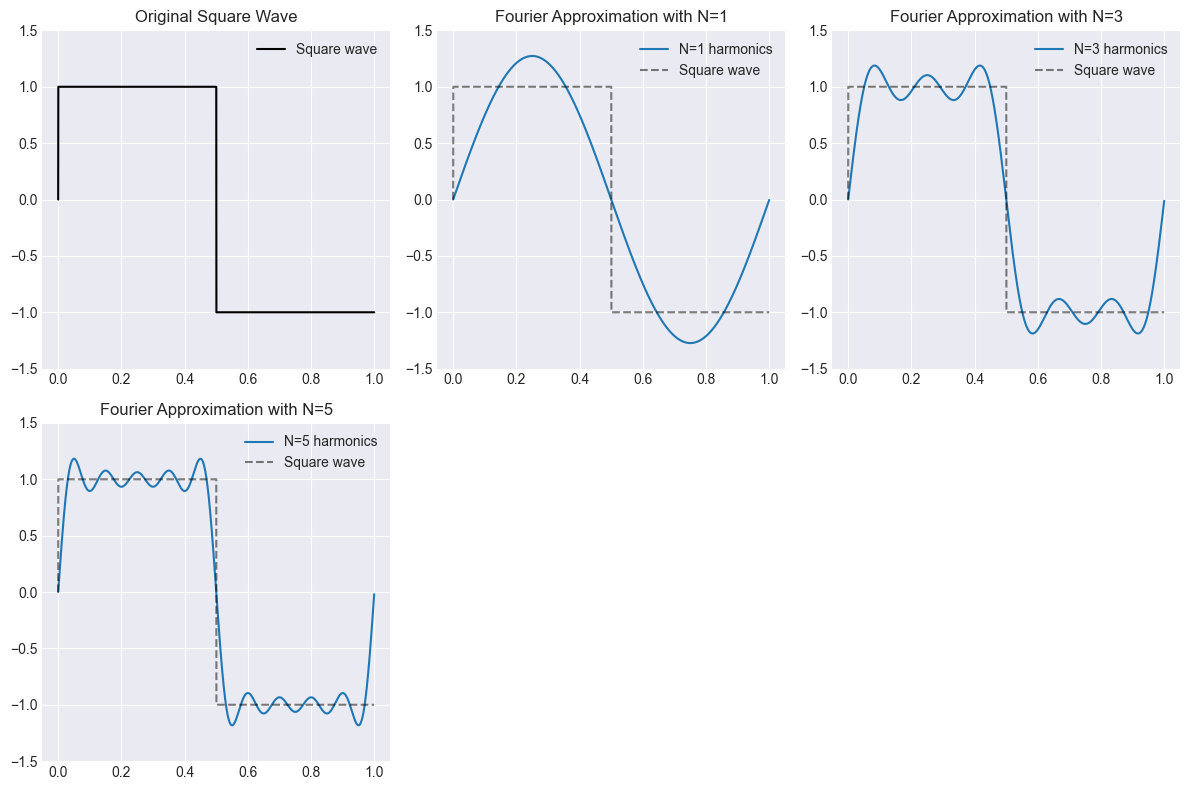

In [68]:
# Create the time vector
# np.linspace generates evenly spaced numbers over a specified interval.
# We use endpoint=False because the interval is periodic.
t = np.linspace(0.0, T, N, endpoint=False)

# generate original square wave
square = square_wave(t)

plt.figure(figsize=(12, 8))
# Plot original square wave
plt.subplot(2, 3, 1)
plt.plot(t, square, 'k', label="Square wave")
plt.title("Original Square Wave")
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()
# Plot Fourier reconstructions
for i, Nh in enumerate(harmonics, start=2):
    plt.subplot(2, 3, i)
    y = square_wave_fourier(t, f0, Nh)
    plt.plot(t, y, label=f"N={Nh} harmonics")
    plt.plot(t, square, 'k--', alpha=0.5, label="Square wave")
    plt.title(f"Fourier Approximation with N={Nh}")
    plt.ylim(-1.5, 1.5)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

Now lets see how adding more than just 5 harmonics improves the representation

In [69]:
# Reuse the time vector and original square wave from above
# Start a new figure with a new list of harmonics
harmonics = [10, 20, 50, 100, 500]
plt.figure(figsize=(12, 8))

# Plot original square wave
plt.subplot(2, 3, 1)
plt.plot(t, square, 'k', label="Square wave")
plt.title("Original Square Wave")
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()

# Plot Fourier reconstructions
for i, Nh in enumerate(harmonics, start=2):
    plt.subplot(2, 3, i)
    y = square_wave_fourier(t, f0, Nh)
    plt.plot(t, y, label=f"N={Nh} harmonics")
    plt.plot(t, square, 'k--', alpha=0.5, label="Square wave")
    plt.title(f"Fourier Approximation with N={Nh}")
    plt.ylim(-1.5, 1.5)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

What we can see happen is that as more harmonics are added the lines become much 'straighter' in the sense that the oscillations about both the flat part of the square wave and transition part of the square wave are minimised. The more harmonics, the much sharper and more accurate the reconstruction is. One interesting point to note is that the points close to the transition from 1 to -1 or -1 to 1 are where the highest error occurs, with a gradual increase in oscilations before the transition and some slight overshooting at these points.

Now I want to try and decompose the reconstructed square wave back into its components. To do this, I am evaluating the naive and fast DFT algorithms. I need to modify the below code to apply it to the square wave generated and note any differences.

In [ ]:
# 2. Apply the DFT and time the execution
def naive_dft(x):
    """
    Compute the Discrete Fourier Transform (DFT) of a 1D signal.
    
    This is a "naïve" implementation that directly follows the DFT formula,
    which has a time complexity of O(N^2).
    
    Args:
        x (np.ndarray): The input signal, a 1D NumPy array.

    Returns:
        np.ndarray: The complex-valued DFT of the input signal.
    """
    N = len(x)
    # Create an empty array of complex numbers to store the DFT results
    X = np.zeros(N, dtype=np.complex128)

    # Iterate through each frequency bin (k) - Previous non-vectorized implementation
    # for k in range(N):
    #     # For each frequency bin, sum the contributions from all input samples (n)
    #     for n in range(N):
    #         # The core DFT formula: x[n] * e^(-2j * pi * k * n / N)
    #         angle = -2j * np.pi * k * n / N
    #         X[k] += x[n] * np.exp(angle)

    # VECTORISED IMPLEMENTATION
    # Create n and k indices    
    n = np.arange(N).reshape(1, N)
    k = np.arange(N).reshape(N, 1)

    # Compute DFT matrix efficiently
    W = np.exp((-2j * np.pi * k * n / N)).astype(np.complex128)  # vectorized
    X = W @ x

    return X    

# Construct a square wave using 50 harmonics
signal = square_wave_fourier(t, f0, 50)
# Time the naïve DFT implementation
start_time_naive = time.time()
dft_result = naive_dft(signal)
end_time_naive = time.time()
naive_duration = end_time_naive - start_time_naive

# Time NumPy's FFT implementation
start_time_fft = time.time()
fft_result = np.fft.fft(signal)
end_time_fft = time.time()
fft_duration = end_time_fft - start_time_fft

# 3. Print Timings and Verification
print("--- DFT/FFT Performance Comparison ---")
print(f"Naïve DFT Execution Time: {naive_duration:.6f} seconds")
print(f"NumPy FFT Execution Time: {fft_duration:.6f} seconds")
# It's possible for the FFT to be so fast that the duration is 0.0, so we handle that case.
if fft_duration > 0:
    print(f"FFT is approximately {naive_duration / fft_duration:.2f} times faster.")
else:
    print("FFT was too fast to measure a significant duration difference.")

# Check if our implementation is close to NumPy's result
# np.allclose is used for comparing floating-point arrays.
print(f"\nOur DFT implementation is close to NumPy's FFT: {np.allclose(dft_result, fft_result)}")

# 4. Prepare for Plotting
# Generate the frequency axis for the plot.
# np.fft.fftfreq returns the DFT sample frequencies.
# We only need the first half of the frequencies (the positive ones) due to symmetry.
xf = np.fft.fftfreq(N, d=T/N)[:N//2]
# We normalize the magnitude by N and multiply by 2 to get the correct amplitude.
magnitude = 2.0/N * np.abs(dft_result[0:N//2])

# 5. Visualize the Results
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the original time-domain signal
ax1.plot(t, signal, color='c')
ax1.set_title('Input Sine Wave Signal', fontsize=16)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_xlim(0, 1.0) # Show a few cycles of the sine wave
ax1.grid(True)

# Plot the frequency-domain signal (magnitude of the DFT)
ax2.stem(xf, magnitude, basefmt=" ")
ax2.set_title(
    'Discrete Fourier Transform (Magnitude Spectrum)',
    fontsize=16
    )
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Magnitude', fontsize=12)
ax2.set_xlim(0, 50) # Focus on lower frequencies
ax2.grid(True)

# Add vertical lines for the first ten frequencies
for i in range(20):
    if i < len(xf) and i % 2 == 1: # Only plot odd harmonics
        ax2.axvline(
            xf[i], color='r', linestyle='--', alpha=0.7,
            label=f'f{i}: {i}* f0 = {xf[i]:.1f} Hz'
            )
        
# Only show labels for first 3 frequencies to avoid cluttering
ax2.legend()

plt.tight_layout()
plt.show()

--- DFT/FFT Performance Comparison ---
Naïve DFT Execution Time: 0.167253 seconds
NumPy FFT Execution Time: 0.000000 seconds
FFT was too fast to measure a significant duration difference.

Our DFT implementation is close to NumPy's FFT: True


The original code shows how siginficantly the FFT and the Naive FT behave in Numpy. To complete the question, we need to change from Numpy to TensorFlow.

In [71]:
# 2. Apply the DFT and time the execution
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("PyTorch Version:", torch.__version__)

t_tensor = torch.from_numpy(t).to(device)

# Define square wave function
def square_wave_tensor(t):
    return torch.sign(torch.sin(2.0 * torch.pi * f0 * t))

# Fourier series approximation of square wave
def square_wave_fourier_tensor(t, f0, N):
    result = torch.zeros_like(t)
    for k in range(N):
        n = 2 * k + 1  # Fourier series of a square wave only contains odd harmonics
        result += torch.sin(2 * torch.pi * n * f0 * t) / n # add harmonics to reconstruct square function
    return (4 / torch.pi) * result


def naive_dft(x):
    """
    Compute the Discrete Fourier Transform (DFT) of a 1D signal.
    
    This is a "naïve" implementation that directly follows the DFT formula,
    which has a time complexity of O(N^2).
    
    Args:
        x (np.ndarray): The input signal, a 1D NumPy array.

    Returns:
        np.ndarray: The complex-valued DFT of the input signal.
    """
    N = len(x)

    # # Create an empty array of complex numbers to store the DFT results
    # X = torch.zeros(N, dtype=torch.complex128)

    # # Iterate through each frequency bin (k)
    # for k in range(N):
    #     # For each frequency bin, sum the contributions from all input samples (n)
    #     for n in range(N):
    #         # The core DFT formula: x[n] * e^(-2j * pi * k * n / N)
    #         angle = -2j * torch.pi * k * n / N
    #         X[k] += x[n] * torch.exp(torch.tensor(angle))

    # VECTORISED IMPLEMENTATION
    # Create n and k indices    
    n = torch.arange(N).reshape(1, N)
    k = torch.arange(N).reshape(N, 1)

    # Compute DFT matrix efficiently
    W = torch.exp((-2j * torch.pi * k * n / N)).to(torch.complex128)  # vectorized
    X = W @ x.to(torch.complex128)

    return X    

# Construct a square wave using 50 harmonics
signal = square_wave_fourier_tensor(t_tensor, f0, 50)
# Time the naïve DFT implementation
start_time_naive = time.time()
dft_result = naive_dft(signal)
end_time_naive = time.time()
naive_duration = end_time_naive - start_time_naive

# Time NumPy's FFT implementation
start_time_fft = time.time()
fft_result = torch.fft.fft(signal)
end_time_fft = time.time()
fft_duration = end_time_fft - start_time_fft

# 3. Print Timings and Verification
print("--- DFT/FFT Performance Comparison ---")
print(f"Naïve DFT Execution Time for Tensor: {naive_duration:.6f} seconds")
print(f"Tensor FFT Execution Time: {fft_duration:.6f} seconds")
# It's possible for the FFT to be so fast that the duration is 0.0, so we handle that case.
if fft_duration > 0:
    print(f"FFT is approximately {naive_duration / fft_duration:.2f} times faster.")
else:
    print("FFT was too fast to measure a significant duration difference.")

# Check if our implementation is close to NumPy's result
# np.allclose is used for comparing floating-point arrays.
print(f"\nOur DFT implementation is close to NumPy's FFT: {torch.allclose(dft_result, fft_result)}")

# 4. Prepare for Plotting
# Generate the frequency axis for the plot.
# np.fft.fftfreq returns the DFT sample frequencies.
# We only need the first half of the frequencies (the positive ones) due to symmetry.
xf = torch.fft.fftfreq(N, d=T/N)[:N//2]
# We normalize the magnitude by N and multiply by 2 to get the correct amplitude.
magnitude = 2.0/N * torch.abs(dft_result[0:N//2])

# 5. Visualize the Results
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the original time-domain signal
ax1.plot(t, signal, color='c')
ax1.set_title('Input Sine Wave Signal', fontsize=16)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_xlim(0, 1.0) # Show a few cycles of the sine wave
ax1.grid(True)

# Plot the frequency-domain signal (magnitude of the DFT)
ax2.stem(xf, magnitude, basefmt=" ")
ax2.set_title(
    'Discrete Fourier Transform (Magnitude Spectrum)',
    fontsize=16
    )
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Magnitude', fontsize=12)
ax2.set_xlim(0, 50) # Focus on lower frequencies
ax2.grid(True)

# Add vertical lines for the first ten frequencies
for i in range(20):
    if i < len(xf) and i % 2 == 1: # Only plot odd harmonics
        ax2.axvline(
            xf[i], color='r', linestyle='--', alpha=0.7,
            label=f'f{i}: {i}* f0 = {xf[i]:.1f} Hz'
            )
        
# Only show labels for first 3 frequencies to avoid cluttering
ax2.legend()

plt.tight_layout()
plt.show()

PyTorch Version: 2.8.0+cpu
--- DFT/FFT Performance Comparison ---
Naïve DFT Execution Time for Tensor: 0.073606 seconds
Tensor FFT Execution Time: 0.000000 seconds
FFT was too fast to measure a significant duration difference.

Our DFT implementation is close to NumPy's FFT: False


# Question 2

## Numpy

Start as the normal NP implementation

In [2]:
# Import the Best Features
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
# Introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# For machine learning we use the data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# The label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [4]:
# Split into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled 
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

In [5]:
# Center data to have a mean of 0 as this is assumed by PCA and ensures bias is removed
mean = np.mean(X_train, axis=0) 
X_train -= mean
X_test -= mean

In [6]:
# Eigen-decomposition 
U, S, V = np.linalg.svd(X_train, full_matrices=False) # V is the eigenvectors and S the eigenvalues (standard deviation)
components = V[:n_components] # Only take the number of principle vectors we want
eigenfaces = components.reshape((n_components, h, w)) # Reshape to image dimensions for visualization

In [7]:
# Project into PCA subspace 
X_transformed = np.dot(X_train, components.T) 
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T) 
print(X_test_transformed.shape)

(966, 150)
(322, 150)


In [ ]:
import matplotlib.pyplot as plt

# Qualitative evaluation of the predictions using matplotlib 
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    # Make an appropriate figure size
    plt.figure(figsize=(2 * n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35) 
    
    # Plot each individual face
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1) 
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray) 
        plt.title(titles[i], size=12)
        plt.xticks(()) 
        plt.yticks(())

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])] 
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

(966,)


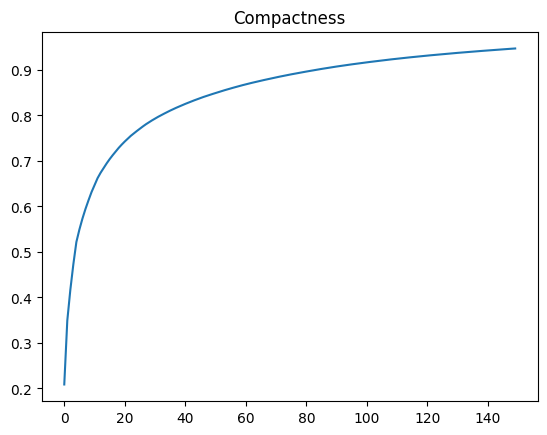

In [ ]:
# Plot the cumulative explained variance to show how many components are needed to explain a certain amount of variance
explained_variance = (S ** 2) / (n_samples - 1) 
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var 
ratio_cumsum = np.cumsum(explained_variance_ratio) 
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)

plt.plot(eigenvalueCount, ratio_cumsum[:n_components]) 
plt.title('Compactness')
plt.show()

In [10]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
#build random forest 

estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150) 
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]

predictions = estimator.predict(X_test_transformed) 
correct = predictions==y_test
total_test = len(X_test_transformed) 
#print("Gnd Truth:", y_test)
print("Total Testing", total_test) 
print("Predictions", predictions) 
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct)) 
print("Accuracy:",np.sum(correct)/total_test)

print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions [3 3 6 3 3 3 3 1 3 3 3 4 3 3 3 3 6 3 3 4 1 1 3 3 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 1 1 3 3 3 4 3 3 3 3 3 1 2 1 3 3 3 4 1 3 3 3 5 1 4 1 3 6 6 3 3
 3 2 3 1 3 3 6 3 2 3 3 3 3 3 3 2 5 3 3 3 1 3 1 1 1 6 3 3 3 3 3 3 3 3 3 1 3
 1 6 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 6 3 3 4 3 3 1 3 2 3 3 1 3 3 3 3
 4 1 1 3 3 3 3 3 6 1 3 3 6 6 5 1 3 3 5 1 3 3 3 3 3 1 5 3 3 3 3 3 3 3 3 1 3
 3 3 3 3 2 4 3 2 3 6 3 3 3 3 3 3 3 3 3 3 1 4 2 3 3 1 5 3 3 4 3 3 1 3 3 3 3
 3 1 1 3 3 3 3 3 3 3 3 3 3 1 3 6 3 3 3 4 3 3 3 3 3 3 3 4 4 4 3 4 3 4 3 1 3
 3 3 3 3 1 3 6 6 1 6 1 1 1 3 3 6 3 3 3 3 3 1 1 3 3 3 1 3 3 3 4 3 3 5 3 3 1
 3 4 3 3 3 6 3 3 1 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 4 3]
Which Correct: [ True  True  True  True  True  True False  True  True  True  True False
  True False  True  True False  True  True  True  True False  True False
 False  True False  True  True  True False  True  True  True  True  True
  True  True  True False  True False  True  True  True False False  True
 False  T

C:\Users\cpdav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cpdav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cpdav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

## Torch

Now look at the torch implementation

In [ ]:
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.8.0+cpu


In [ ]:
# Introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# For machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = torch.from_numpy(lfw_people.data).to(device)
n_features = X.shape[1]

# The label to predict is the id of the person
y = torch.from_numpy(lfw_people.target).to(device)
target_names = lfw_people.target_names # Numpy but Numpy strings
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [ ]:
print(type(X))
print(type(n_features))
print(type(y))
print(type(target_names))
print(type(n_classes))

<class 'torch.Tensor'>
<class 'int'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'int'>


In [ ]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled 
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

In [ ]:
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
# Center data 
mean = torch.mean(X_train, axis=0) 
X_train -= mean
X_test -= mean

In [ ]:
#Eigen-decomposition 
U, S, V = torch.linalg.svd(X_train, full_matrices=False) 
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

In [ ]:
print(type(U))
print(type(S))
print(type(V))
print(type(components))
print(type(eigenfaces))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
# Project into PCA subspace 
# In the previous numpy case, we used np.dot which is equivalent to torch.matmul or the @ operator in PyTorch.
X_transformed = torch.matmul(X_train, components.T) 
print(X_transformed.shape)
X_test_transformed = torch.matmul(X_test, components.T) 
print(X_test_transformed.shape)

torch.Size([966, 150])
torch.Size([322, 150])


In [ ]:
print(type(X_transformed))
print(type(X_test_transformed))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
import matplotlib.pyplot as plt

# Qualitative evaluation of the predictions using matplotlib 
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits""" 
    plt.figure(figsize=(2 * n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35) 
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1) 
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray) 
        plt.title(titles[i], size=12)
        plt.xticks(()) 
        plt.yticks(())

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])] 
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

torch.Size([966])


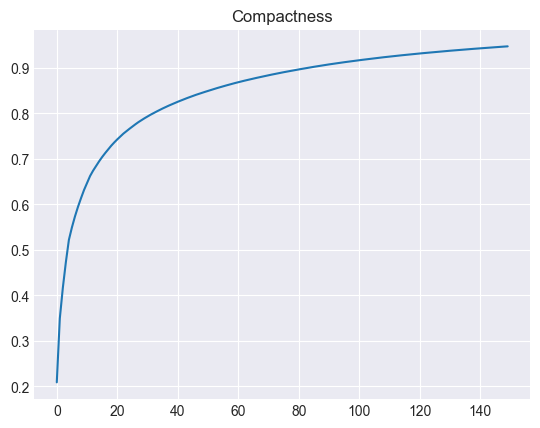

In [ ]:
explained_variance = (S ** 2) / (n_samples - 1) 
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var 
ratio_cumsum = torch.cumsum(explained_variance_ratio, 0) # Can also use np.cumsum and keep the torch file type
print(ratio_cumsum.shape)
eigenvalueCount = torch.arange(n_components)

plt.plot(eigenvalueCount, ratio_cumsum[:n_components]) 
plt.title('Compactness')
plt.show()

In [ ]:
print(type(explained_variance))
print(type(total_var))
print(type(explained_variance_ratio))
print(type(ratio_cumsum))
print(type(eigenvalueCount))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
#build random forest 

estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150) 
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]

predictions = torch.from_numpy(estimator.predict(X_test_transformed)) 
correct = predictions==y_test
total_test = len(X_test_transformed) 
#print("Gnd Truth:", y_test)
print("Total Testing", total_test) 
print("Predictions", predictions) 
print("Which Correct:",correct)
print("Total Correct:", torch.sum(correct)) 
print("Accuracy:", torch.sum(correct)/total_test)

print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions tensor([3, 3, 6, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 1, 1, 3, 3,
        1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3,
        4, 3, 3, 3, 3, 3, 1, 2, 1, 3, 3, 3, 6, 1, 6, 1, 3, 5, 3, 4, 1, 1, 6, 6,
        3, 3, 3, 1, 3, 1, 1, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 1, 5, 6, 3, 3, 1, 3,
        3, 1, 1, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 6, 3, 3, 3, 1, 4, 1, 3,
        1, 3, 3, 1, 3, 4, 4, 1, 1, 3, 6, 6, 6, 3, 3, 4, 3, 3, 1, 3, 1, 3, 3, 1,
        3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 6, 3, 3, 3, 6, 5, 5, 1, 3, 3, 5, 1,
        3, 3, 1, 3, 3, 1, 5, 3, 3, 2, 3, 5, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 5, 3,
        2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 4, 2, 6, 2, 2, 5, 3, 3, 4, 4,
        3, 0, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3,
        3, 4, 1, 3, 3, 3, 3, 3, 1, 5, 4, 4, 3, 4, 3, 4, 3, 1, 3, 3, 3, 3, 3, 1,
        3, 6, 6, 1, 6, 1, 1, 1, 3, 3, 6, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3,
        3,

In [ ]:
print(type(estimator))
print(type(predictions))
print(type(correct))
print(type(total_test))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'int'>


# Question 3

## 3.1

This is the only one where we need to do clusters

In [ ]:
# Pre-process the code
# The following code could be used for data preprocessing if using pytorch 
X = lfw_people.images
Y = lfw_people.target 

# Verify the value range of X_train. No normalization is necessary in this case, 
# as the input values already fall within the range of 0.0 to 1.0.
print("X_min:", X.min(), "| X_train_max:", X.max()) 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42) 
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)

y_train = torch.from_numpy(y_train).long().to(device)
y_test = torch.from_numpy(y_test).long().to(device)
X_train = X_train[:, torch.newaxis, :, :]
X_test = X_test[:, torch.newaxis, :, :] 
print("X_train shape:", X_train.shape)

X_min: 0.0 | X_train_max: 1.0
X_train shape: torch.Size([966, 1, 50, 37])


In [ ]:
# Build a CNN with PyTorch using two Conv2D 3x3 layers with 32 filters each and a dense layer classification
# Use Adam optimiser and CrossEntropyLoss 

# Train the model and evaluate the accuracy on the test set
# You may use GPU if available
depth = 32
batch_size = 64
num_epochs = 25
categories = n_classes

# Convert y to categorical
y_train_cat = torch.nn.functional.one_hot(y_train, num_classes=categories).to(device)
y_test_cat = torch.nn.functional.one_hot(y_test, num_classes=categories).to(device)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report

class CNN(nn.Module):
    def __init__(self, depth, categories, h, w):
        """
        Building blocks of convolutional neural network.

        Parameters:
            * in_channels: Number of channels in the input image (for grayscale images, 1)
            * num_classes: Number of classes to predict. In our problem, 10 (i.e digits from  0 to 9).
        """
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, depth, kernel_size=3, padding=1)            # (n, n) -> (n, n)
        self.conv2 = nn.Conv2d(depth, depth, kernel_size=3, padding=1)        # 32 -> 32 as it says only 32 filters

        # To figure out final size for flatten variable, pass dummy input
        with torch.no_grad():
            dummy = torch.zeros(1, 1, h, w)  # (batch, channels, H, W)
            out = self._forward_conv(dummy)
            flat_size = out.view(1, -1).size(1) # Could calculate manually if needed, but this is easier

        self.fc1 = nn.Linear(flat_size, categories)

    # Convolutional layers part of forward pass
    def _forward_conv(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        return x
    
    # Full forward pass explanation
    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)  # Flatten layer, -1 flatttens, x.size(0) is batch size
        x = self.fc1(x) # A final dense layer for classification, apply activation is BAD here idk why
        return x 
    

# Create model
h = X_train.shape[2] 
w = X_train.shape[3]

# Assumes X_train is (Number of Samples (966), 
# Number of Channels (greyscale is 1), Image Height (50), image width (37)) in pytorch
# Note that tf goes (966, 50, 37, 1)
model = CNN(depth, categories, h, w)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # Always sparse, expects number for input, no need for cat
optimizer = optim.Adam(model.parameters())

# Create linked datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train) # y_train_cat - No need for cat with CrossEntropyLoss
test_dataset = TensorDataset(X_test, y_test) # y_test_cat - No need for cat with CrossEntropyLoss
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Batches the data and shuffles for training, shuffled twice now
test_loader = DataLoader(test_dataset, batch_size=batch_size) # Batches the data

# Training loop - no validation set needed as no hyperparameter tuning necessary - Question discusses what hyperparameters to use
for epoch in range(num_epochs):
    model.train() # Train model
    running_loss = 0.0 # set loss to 0
    
    # Iterate over each batch
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad() # Reset optimiser
        outputs = model(X_batch) # Forward pass
        loss = criterion(outputs, y_batch) # Compute loss
        loss.backward() # Backpropagation
        optimizer.step() # Update weights
        running_loss += loss.item() # Accumulate loss
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad(): # Just don't compute gradients as we are evaluating
    for X_batch, y_batch in test_loader:
        # Predict for the batch
        outputs = model(X_batch)
        _, predictions = torch.max(outputs, 1) # Find the most likely class
        
        # Extend the lists with current batch results
        all_predictions.extend(predictions)
        all_labels.extend(y_batch)

print(classification_report(all_labels, all_predictions, target_names=target_names))

Epoch 1/25, Loss: 1.9342
Epoch 2/25, Loss: 1.6786
Epoch 3/25, Loss: 1.4765
Epoch 4/25, Loss: 1.2366
Epoch 5/25, Loss: 0.9441
Epoch 6/25, Loss: 0.6466
Epoch 7/25, Loss: 0.4980
Epoch 8/25, Loss: 0.4382
Epoch 9/25, Loss: 0.3384
Epoch 10/25, Loss: 0.2518
Epoch 11/25, Loss: 0.1851
Epoch 12/25, Loss: 0.1499
Epoch 13/25, Loss: 0.1139
Epoch 14/25, Loss: 0.0967
Epoch 15/25, Loss: 0.0984
Epoch 16/25, Loss: 0.0657
Epoch 17/25, Loss: 0.0531
Epoch 18/25, Loss: 0.0324
Epoch 19/25, Loss: 0.0250
Epoch 20/25, Loss: 0.0185
Epoch 21/25, Loss: 0.0153
Epoch 22/25, Loss: 0.0174
Epoch 23/25, Loss: 0.0128
Epoch 24/25, Loss: 0.0122
Epoch 25/25, Loss: 0.0294
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.71      0.97      0.82        60
  Donald Rumsfeld       0.82      0.67      0.73        27
    George W Bush       0.93      0.91      0.92       146
Gerhard Schroeder       0.67      0.80      0.73        25
    

## Question 3.3

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Here are the classes in the dataset, as well as 10 random images from each:
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck


In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report


In [117]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print("CUDA is not available. Training on CPU may be slow.")

# Hyper-parameters
num_epochs = 35
learning_rate = 0.1
batch_size = 128
depth = 64

CUDA is not available. Training on CPU may be slow.


In [118]:
# Setup and normalise the data by pre-processing - easier than Tensorflow
transform_train = transforms.Compose([
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # Normalise to mean and std of CIFAR-10, pre-computed for each channel
    transforms.RandomHorizontalFlip(), # Data augmentation to help with overfitting
    transforms.RandomCrop(32, padding=4, padding_mode='reflect') # Data augmentation to help with overfitting
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [ ]:
# Load the datasets for each
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=6) #num_workers depends on your CPU

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=6) 

100%|██████████| 170M/170M [00:24<00:00, 6.97MB/s] 


In [120]:
# In PyTorch, we always use custom 'Modules' as classes for better robustness 
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1): # How many inputs and what depth
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # Used to normalise everything in between to ensure no crazy values
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x): # Forward pass, what happens when you pass data through
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
# Now make resnet 18 - outside of scope but combination of blocks in different ways
# Resnet 18 is unique in that it has 18 layers and uses a forward pass to add the input to the output of a few layers for vanishing gradients
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4) # Global average pooling to actually reduce size before flatten and dense linear out
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [122]:
model = ResNet18().to(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

# Model info
print("Model No. of Parameters:", sum([param.nelement() for param in model.parameters()]))
print(model)

Model No. of Parameters: 11173962
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64

In [124]:
criterion = nn.CrossEntropyLoss() # Good for multi-class classification, expects class labels not one-hot
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4) # Weight decay is L2 regularization, SGD is really good for speed

# Piecewise Linear Schedule - allows you to get 94% accuracy in 1/10th of the time
total_step = len(trainloader)
sched_linear_1 = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.005, max_lr=learning_rate, step_size_up=15, step_size_down=15, mode='triangular') 
sched_linear_3 = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.005/learning_rate, end_factor=0.005/5) 
scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[sched_linear_1, sched_linear_3], milestones=[30]) 

In [125]:
# Train the model
model.train()
print("> Training")
start = time.time()
for epoch in range(num_epochs):
    
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}], Loss: {:.5f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    scheduler.step() # Update learning rate

end = time.time()
elapsed = end - start
print("Training took " + str(elapsed) + " secs or " + str(elapsed/60) + " mins in total")

> Training


KeyboardInterrupt: 

In [ ]:
# Test the model
print("> Testing")
start = time.time()
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    # Iterate over the test data, produce a model and find the test accuracy.
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy: {} %'.format(100 * correct / total))

end = time.time()
elapsed = end - start
print("Testing took " + str(elapsed) + " secs or " + str(elapsed/60) + " mins in total")